#  Machine translation

La tarea aquí presentada consiste en traducir de un idioma a otro utilizando técnicas de deep learning. En partícular, la tarea es traducir del frances al ingles utilizando una red LSTM sequence to sequences. 

Ejemplo:

`elle est non seulement belle mais aussi intelligente. => she is not only beautiful but also intelligent.`

El tutorial está basado en [Pytorch From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), pero en vez de attention se utilizará LSTM.

In [ ]:
# Imports
import io
import re
import math
import random
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [ ]:
# Download the data
import requests, zipfile

zip_file_url = 'https://download.pytorch.org/tutorial/data.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:

N = 10  # print the 10 first lines
with open('data/eng-fra.txt') as f:
  for i in range(N):
    line = next(f).strip()
    print(line)

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
    self.n_words = 3  # Count SOS and EOS and PAD

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1


def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )


def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s


def readLangs(lang1, lang2, reverse=False):
  print("Reading lines...")

  # Read the file and split into lines
  lines = io.open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
      read().strip().split('\n')

  # Split every line into pairs and normalize
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
      pairs = [list(reversed(p)) for p in pairs]
      input_lang = Lang(lang2)
      output_lang = Lang(lang1)
  else:
      input_lang = Lang(lang1)
      output_lang = Lang(lang2)

  return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and \
      len(p[1].split(' ')) < MAX_LENGTH and \
      p[1].startswith(eng_prefixes)


def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

Vamos a explorar un poco de los lenguajes. Ver la cantidad de palabras y su distribución.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4346
eng 2804
['c est un mordu de cinema .', 'he s a movie buff .']


In [ ]:
def plot_lang(lang, top_k=100):
  words = list(lang.word2count.keys())
  words.sort(key=lambda w: lang.word2count[w], reverse=True)
  print(words[:top_k])
  count_occurences = sum(lang.word2count.values())

  accumulated = 0
  counter = 0

  while accumulated < count_occurences * 0.8:
    accumulated += lang.word2count[words[counter]]
    counter += 1

  print(f"The {counter * 100 / len(words)}% most common words "
        f"account for the {accumulated * 100 / count_occurences}% of the occurrences")
  plt.bar(range(100), [lang.word2count[w] for w in words[:top_k]])
  plt.show()

['.', 'je', 'suis', 'est', 'vous', 'pas', 'de', 'il', 'nous', 'tu', 'etes', 'ne', 'es', 'en', 'a', 'n', 'un', 'sommes', 'elle', 'la', 'tres', 'c', 'que', 'le', 'sont', 'j', 'une', 'd', 'ai', 'pour', 'l', 'ils', 'plus', 'ce', 'des', 'me', 'vais', 'elles', 'moi', '!', 'mon', 'trop', 'train', 'fort', 'si', 'ici', 'du', 'toujours', 'toi', 'tout', 'tous', 'les', '?', 'vraiment', 'sur', 't', 'te', 'm', 'dans', 'avec', 'avoir', 'encore', 'qu', 'tom', 'votre', 'au', 'peur', 'y', 'desole', 'bien', 'ca', 'bon', 'fais', 'toutes', 'heureux', 'faire', 'etre', 'son', 'aussi', 'assez', 'lui', 'tellement', 'ma', 'mes', 'fatigue', 'par', 'et', 'fait', 'ton', 'se', 'juste', 'maintenant', 'grand', 'desolee', 'avons', 'allons', 'peu', 'deux', 'on', 'vieux']
The 4.674188349067465% most common words account for the 80.0371543427945% of the occurrences


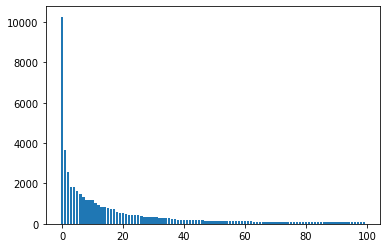

In [ ]:
plot_lang(input_lang)

['.', 'i', 're', 'you', 'm', 'he', 'not', 'is', 'a', 'to', 'we', 's', 'the', 'very', 'are', 'of', 'she', 'am', 'they', 'in', 'going', 'my', 'for', 'all', 'at', 'here', 'with', 'that', 'good', 'as', 'your', 't', 'me', 'too', 'this', 'sorry', 'on', 'glad', 'it', 'than', 'now', 'happy', 'about', '?', 'aren', 'so', 'tired', 'afraid', 'sure', 'right', 'an', 'his', 'out', 'really', 'one', 'busy', 'still', 'just', 'old', 'always', 'tom', 'looking', 'be', 'friend', 'no', 'her', 'ready', 'by', '!', 'and', 'teacher', 'from', 'getting', 'him', 'alone', 'being', 'home', 'up', 'have', 'go', 'doing', 'help', 'see', 'proud', 'man', 'married', 'kind', 'who', 'waiting', 'yet', 'young', 'person', 'done', 'late', 'friends', 'new', 'anymore', 'hungry', 'such', 'sick']
The 4.85540878257765% most common words account for the 80.00500226665207% of the occurrences


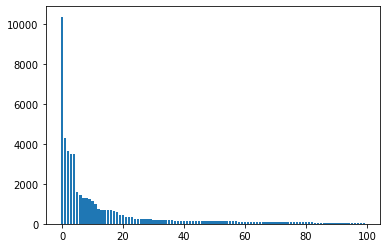

In [ ]:
plot_lang(output_lang)

## Para entrenar

El modelo consistirá en un encoder que con

Vamos a mapear las entradas/saludas de nuestro modelo a un vector de IDs.

```
Representation of an input sentece:
[2, 2, 2, 2, 2, 2, 0, 3, 4, 5, 6, 1]
PAD PAD PAD PAD PAD PAD SOS j ai ans . EOS

Representation of an partial sentece:
[0, 3, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2]
SOS i m . EOS PAD PAD PAD PAD PAD PAD PAD

Representation of an target sentece:
[3, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2]
i m . EOS PAD PAD PAD PAD PAD PAD PAD PAD
```

Es importante n

In [ ]:
def to_train(input_lang, output_lang, pairs, max_len=MAX_LENGTH+2):
  x_input = []
  x_output = []
  target = []
  for i, o in pairs:
    s_i = [2] * max_len + [0] + [input_lang.word2index[w] for w in i.split(" ")] + [1]
    s_o = [0] + [output_lang.word2index[w] for w in o.split(" ")] + [1] + [2] * max_len
    s_to = s_o[1:] + [2]
    x_input.append(s_i[-max_len:])
    x_output.append(s_o[:max_len])
    target.append(s_to[:max_len])
  return x_input, x_output, target

In [ ]:
x_input, x_partial, y = to_train(input_lang, output_lang, pairs)

In [ ]:
print('Representation of an input sentece:')
print(x_input[0])
print(' '.join([input_lang.index2word[w] for w in x_input[0]]))
print('\nRepresentation of an partial sentece:')
print(x_partial[0])
print(' '.join([output_lang.index2word[w] for w in x_partial[0]]))
print('\nRepresentation of an target sentece:')
print(y[0])
print(' '.join([output_lang.index2word[w] for w in y[0]]))

Representation of an input sentece:
[2, 2, 2, 2, 2, 2, 0, 3, 4, 5, 6, 1]
PAD PAD PAD PAD PAD PAD SOS j ai ans . EOS

Representation of an partial sentece:
[0, 3, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2]
SOS i m . EOS PAD PAD PAD PAD PAD PAD PAD

Representation of an target sentece:
[3, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2]
i m . EOS PAD PAD PAD PAD PAD PAD PAD PAD


In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy

def masked_categorical_crossentropy(y_true, y_pred):
    y_true = K.cast(K.flatten(y_true), np.int32)
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])
    loss = sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.where(y_true==2, 0.0, 1.0)
    return loss * mask

In [ ]:
hidden = 300

ie = Input((MAX_LENGTH+2,), name='origen')
e = Embedding(input_lang.n_words, hidden, name='embedding-org')(ie)
_, hs, hc = LSTM(hidden, name='encoder', return_state=True)(e)

id = Input((MAX_LENGTH+2,), name='dest')
e = Embedding(output_lang.n_words, hidden, name='embedding-dest')(id)
d = LSTM(hidden, name='decoder', return_sequences=True)(e, initial_state=[hs, hc])
d = Dense(output_lang.n_words, activation='softmax')(d)

model = Model(inputs=[ie, id], outputs=d)
model.compile(loss=masked_categorical_crossentropy, optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
origen (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
dest (InputLayer)               [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding-org (Embedding)       (None, 12, 300)      1303800     origen[0][0]                     
__________________________________________________________________________________________________
embedding-dest (Embedding)      (None, 12, 300)      841200      dest[0][0]                       
______________________________________________________________________________________________

In [ ]:
model.fit([np.asarray(x_input), np.asarray(x_partial)], np.asarray(y), epochs=50, batch_size=128)

Epoch 1/50
83/83 [==============================] - 12s 34ms/step - loss: 2.6242
Epoch 2/50
83/83 [==============================] - 3s 32ms/step - loss: 1.8283
Epoch 3/50
83/83 [==============================] - 3s 33ms/step - loss: 1.6250
Epoch 4/50
83/83 [==============================] - 3s 32ms/step - loss: 1.5089
Epoch 5/50
83/83 [==============================] - 3s 32ms/step - loss: 1.3941
Epoch 6/50
83/83 [==============================] - 3s 32ms/step - loss: 1.2881
Epoch 7/50
83/83 [==============================] - 3s 32ms/step - loss: 1.2028
Epoch 8/50
83/83 [==============================] - 3s 31ms/step - loss: 1.1281
Epoch 9/50
83/83 [==============================] - 3s 32ms/step - loss: 1.0623
Epoch 10/50
83/83 [==============================] - 3s 31ms/step - loss: 0.9991
Epoch 11/50
83/83 [==============================] - 3s 32ms/step - loss: 0.9380
Epoch 12/50
83/83 [==============================] - 3s 32ms/step - loss: 0.8786
Epoch 13/50
83/83 [=================

In [ ]:
def gen_translation(model, text, input_lang, output_lang, max_len=MAX_LENGTH+2):

  text =  [2] * max_len + [0] + [input_lang.word2index[w] for w in text.split(" ")] + [1]
  text = np.asarray([text[-max_len:]])
  out = [0] + [2] * max_len
  out = [out[:max_len]]
  for i in range(1, max_len):
    np_out = np.asarray(out)
    p = model.predict([text, np_out])
    out[0][i] = np.argmax(p, axis=-1)[0, i-1]
    if np.argmax(p, axis=-1)[0, i-1] == 1:
      break

  return ' '.join([output_lang.index2word[idx] for idx in out[0]])

In [ ]:
gen_translation(model, pairs[40][0], input_lang, output_lang)

'SOS i m safe . EOS PAD PAD PAD PAD PAD PAD'

In [ ]:

for i in range(40):
  print('> {}'.format(pairs[i][0]))
  print('= {}'.format(pairs[i][1]))
  print('< {}'.format(gen_translation(model,
                                      pairs[i][0],
                                      input_lang,
                                      output_lang)))
  print('*' * 40)

> j ai ans .
= i m .
< SOS i m years old . EOS PAD PAD PAD PAD PAD
****************************************
> je vais bien .
= i m ok .
< SOS i m all right . EOS PAD PAD PAD PAD PAD
****************************************
> ca va .
= i m ok .
< SOS i m fine . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis gras .
= i m fat .
< SOS i m fat . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis gros .
= i m fat .
< SOS i m fat . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis en forme .
= i m fit .
< SOS i m fit . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis touche !
= i m hit !
< SOS i m hit ! EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis touchee !
= i m hit !
< SOS i m hit ! EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis malade .
= i m ill .
< SOS i m sick . EOS PAD PAD PAD PAD PAD PAD
***************

In [ ]:
for i in range(40):
  print('> {}'.format(pairs[-i][0]))
  print('= {}'.format(pairs[-i][1]))
  print('< {}'.format(gen_translation(model,
                                      pairs[-i][0],
                                      input_lang,
                                      output_lang)))
  print('*' * 40)

> j ai ans .
= i m .
< SOS i m years old . EOS PAD PAD PAD PAD PAD
****************************************
> il est un des candidats aux presidentielles americaines .
= he is one of the american presidential candidates .
< SOS he is one of the american presidential candidates . EOS PAD
****************************************
> ils collectent des dons pour l eglise .
= they are collecting contributions for the church .
< SOS they are collecting contributions for the church . EOS PAD PAD
****************************************
> j ai quelques difficultes a compiler ce programme .
= i m having some problems compiling this software .
< SOS i m having some problems compiling this software . EOS PAD
****************************************
> il entreprend des experiences dans son laboratoire .
= he is carrying out experiments in his laboratory .
< SOS he is carrying out experiments in his laboratory . EOS PAD
****************************************
> elle est non seulement belle mais aus